In [1]:
from utils.utils import *
from utils.dataset import *
from bo.multi_objective import *
from models.RNN0 import Encoder, Decoder, Predictor

import torch
from torch.utils.data import DataLoader

from botorch.utils.transforms import normalize, unnormalize

%load_ext autoreload
%autoreload 2

/home/jshe/smiles_vae/env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sample_restrictions = None
acquisition_function = 'qehvi'

In [3]:
DATADIR = './data/gdb13/'
RUNDIR = './runs/train11/'
OUTDIR = './runs/bo02/'
DATASPEC_FILE = os.path.join(DATADIR, 'spec.json')
RUNSPEC_FILE = os.path.join(RUNDIR, 'spec.json')

encoder_weights_file = os.path.join(RUNDIR, 'encoder_weights.pth')
decoder_weights_file = os.path.join(RUNDIR, 'decoder_weights.pth')
predictor_weights_file = os.path.join(RUNDIR, 'predictor_weights.pth')

samples_z_file = os.path.join(OUTDIR, 'samples_z.pt')
samples_scores_file = os.path.join(OUTDIR, 'samples_scores.pt')
candidates_z_file = os.path.join(OUTDIR, 'candidates_z.pt')
candidates_scores_file = os.path.join(OUTDIR, 'candidates_scores.pt')
state_dict_file = os.path.join(OUTDIR, 'state_dict.pt')

dataspec = fetch_params(DATASPEC_FILE)
runspec = fetch_params(RUNSPEC_FILE)

to_hot, from_hot = make_embedding_utils(dataspec)

In [4]:
encoder = Encoder(runspec.L)
encoder.load_state_dict(torch.load(encoder_weights_file, map_location=torch.device('cpu')))
encoder.eval()

decoder = Decoder(runspec.L)
decoder.load_state_dict(torch.load(decoder_weights_file, map_location=torch.device('cpu')))
decoder.eval()

predictor = Predictor(runspec.L)
predictor.load_state_dict(torch.load(predictor_weights_file, map_location=torch.device('cpu')))
predictor.eval()
None

In [5]:
_, testset = make_data(DATADIR, to_hot, n=500)
dataiter = iter(DataLoader(
    testset, 
    batch_size=16 if sample_restrictions is None else 1, 
    shuffle=True
))

means, stds = get_latent_distributions(encoder, testset.hots)
strong_dims = get_important_dimensions(testset.hots, encoder, decoder)

compressed_means = means[strong_dims]
compressed_stds = stds[strong_dims]

z_bounds = torch.stack((
    (compressed_means - 4 * compressed_stds), 
    (compressed_means + 4 * compressed_stds)f
))

score_bounds = torch.Tensor(
    [[0, -10], 
     [1, 0]]
)

unit_bounds = torch.zeros_like(z_bounds)
unit_bounds[1] = 1

In [6]:
if all(os.path.isfile(f) for f in (samples_z_file, samples_scores_file, candidates_z_file, candidates_scores_file)):
    samples_z = torch.load(samples_z_file)
    samples_scores = torch.load(samples_scores_file)
    candidates_z = torch.load(candidates_z_file)
    candidates_scores = torch.load(candidates_scores_file)
    state_dict = torch.load(state_dict_file)
else:
    samples_z, samples_scores = torch.Tensor(), torch.Tensor()
    candidates_z, candidates_scores = torch.Tensor(), torch.Tensor()
    state_dict = None

In [ ]:
for batch in range(1):

    # Sample from dataset
    if sample_restrictions is None:
        sample_z, sample_scores = get_samples(encoder, dataiter)
        sample_z = sample_z[:, strong_dims]
    else:
        sample_z, sample_scores = get_restricted_samples(encoder, dataiter, n=16, restriction=sample_restrictions)

    # Append samples to progress
    samples_z = torch.cat([samples_z, sample_z])
    samples_scores = torch.cat([samples_scores, sample_scores])

    # Optimization baseline
    ref_point = samples_scores.min(0)[0]

    # Acquisition loop
    for _ in range(8):
        z = normalize(torch.cat([samples_z, candidates_z]), z_bounds).detach()
        scores = normalize(torch.cat([samples_scores, candidates_scores]), score_bounds).detach()

        # Fit GP surrogate
        print('Fitting surrogate...')
        surrogate = fit_surrogate(z, scores, state_dict)
        state_dict = surrogate.state_dict()
        
        # Acquire candidate samples
        print('Aquiring candidates...')
        if acquisition_function == 'qehvi':
            new_candidates = optimize_qehvi(surrogate, z, scores, ref_point, unit_bounds)
        elif acquisition_function == 'qnparego':
            new_candidates = optimize_qnparego(surrogate, z, scores)

        # Unnormalize, decompress, filter, and score candidates
        new_candidates = unnormalize(new_candidates, z_bounds)
        new_candidates = decompress(new_candidates, strong_dims, runspec.L)
        new_z, new_scores = filter_and_score(new_candidates, decoder, from_hot)
        if new_z.dim() > 1: new_z = new_z[:, strong_dims]

        # Update samples
        candidates_z = torch.cat([candidates_z, new_z])
        candidates_scores = torch.cat([candidates_scores, new_scores])

(-10.0, 0.0)

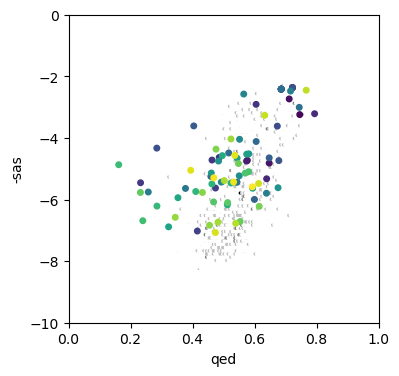

In [9]:
plt.figure(figsize=(4,4))

plt.hexbin(testset.qed, -testset.sas, cmap='binary')

# Candidate Scores
plt.scatter(candidates_scores[:, 0].detach(), candidates_scores[:, 1].detach(), c=range(len(candidates_scores)), s=16)

#plt.scatter(samples_scores[:, 0].detach(), samples_scores[:, 1].detach(), color='red', s=16)

plt.xlabel('qed')
plt.ylabel('-sas')
plt.xlim([0, 1])
plt.ylim([-10, 0])

In [10]:
import pandas as pd

x_hat = decoder(decompress(candidates_z, strong_dims, runspec.L))

mols = [MolFromSmiles(smile) for smile in from_hot(x_hat)]
smiles = set([MolToSmiles(mol) for mol in mols if mol is not None])

candidates = pd.DataFrame(columns=['smile', 'qed', 'sas'])

for i, smile in enumerate(smiles):
    candidates.loc[i] = [smile, QED(MolFromSmiles(smile)), SAS(MolFromSmiles(smile))]

candidates.sort_values(by=['qed'])

,smile,qed,sas
46,[O-]CCSSN=CCCCOO,0.161513,4.870240
31,C1CNCNNC[NH2+]CNNC1,0.231444,5.770748
40,[NH2+]COOCC1CCOO1,0.231955,5.455442
15,N=C1C=C[SH]=C[NH+]=CN1,0.239234,6.688378
9,ClNC=C1C=CC[SH]=C1,0.256886,5.756095
...,...,...,...
1,Nc1[nH]c(=O)sc1-c1ccccc1,0.721865,2.367261
74,Nc1[nH]c(=O)oc1-c1cnccc1Cl,0.743895,3.006863
60,NC1=C(c2sccc2Cl)CC(=O)N1,0.745469,3.242651
21,Nc1ccc(Nc2cccs2)cn1,0.766269,2.450693


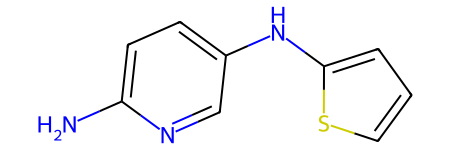

In [22]:
MolFromSmiles('Nc1ccc(Nc2cccs2)cn1')